# Using The Battery Sizing Model
This notebook demonstrates how the battery sizing model module can be used to size a battery given a certain power signal and desired battery lifetime.

In [1]:
import os
import pandas as pd
os.chdir("..")
import battery_sizing_model.blocks as blocks
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import data
power_data = pd.read_csv("power_data/results_IdealBESS_72kW_200kWh_0.csv",
                    skiprows=13, usecols=[1,2])
load_data = pd.read_csv("power_data/model_net_load_kW_1yr_dt-1min.csv")

In [3]:
def process_power(data, max_cap, min_cap):
    """
    Process the power signal so that there is no drift in the 
    SOC if the signal is used for multiple years.
    """
    cap = [100]
    power = []
    temp_power = data.iloc[:,0].to_numpy()
    dt = 60/3600
    for idx, p in enumerate(temp_power):
        if p > 0:
            temp_cap = cap[-1] + p*dt*0.9
        elif p <= 0:
            temp_cap = cap[-1] + p*dt/0.9
        if temp_cap <= max_cap and temp_cap >= min_cap:
            cap.append(temp_cap)
            power.append(p)

    return np.array(power)

def integrate_power(time, data, max_cap, min_cap, init_cap=100):
    """
    Integrate the load signal to get actual battery capacity.
    """
    cap = [init_cap]
    power = []
    for idx, t in enumerate(time):
        if idx < len(time)-1:
            cap.append(cap[-1] + data[idx]*(time[idx+1] - t)*-1)
            power.append(data[idx])
        if cap[-1] > max_cap:
            cap[-1] = max_cap
            power[-1] = 0
        elif cap[-1] < min_cap:
            cap[-1] = min_cap
            power[-1] = 0
    return np.array(cap), np.array(power)*-1

In [4]:
load_cap, load_power = integrate_power(load_data.iloc[:,0].to_numpy(), load_data.iloc[:,1].to_numpy(), 180, 40)

In [5]:
# concatenate power signal to get 10 years of battery usage.
power_init = process_power(power_data, 180, 40)*1e3
power = np.array([])
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)
power = np.append(power, power_init)

## Setup simulation

In [10]:
def setup_sim(pack_capacity):
    # timestep
    dt = 60

    # equivalent circuit block
    ecm = blocks.ECM(
        num_rc_pairs=3, 
        R0=0.00851,  
        R=[1.25430794e-03,2.75299761e-03,2.17698493e-03], 
        C=[1.65306594e+02,1.57444756e-01,1.42594864e+00], 
        timestep=dt
        )

    # Open circuit voltage lookup tabel block
    ocv = blocks.OCVTable()

    # state of charge integrator block
    integrator = blocks.SOCIntegrator(charge_eff=1,discharge_eff=1)

    # SOH estimation model block
    deg_model = blocks.DegradationModel()

    # Battery block
    battery = blocks.Battery(
        cell_chemistry="NCA", 
        pack_capacity=pack_capacity, 
        cell_charge_energy_eff=0.9, 
        cell_discharge_energy_eff=0.9
        )


    print("Battery Capital Cost", battery.capital_cost, "USD")

    # add blocks to simulation
    sim = blocks.BatterySimulator(
        ecm=ecm,
        ocv=ocv,
        integrator=integrator,
        deg_model=deg_model,
        battery=battery,
        soc=0.5
        )

    return sim

## Run Simulation
Here we will use different capacities to see what impact that has on battery lifetime and performance.

In [11]:
sim_200kwh = setup_sim(200e3)
sim_300kwh = setup_sim(300e3)

Battery Capital Cost 30000.0 USD
Battery Capital Cost 45000.0 USD


In [15]:
sim_200kwh.run(power=power, timestep=60)

CapacityError: State of charge is greater than the current state of health or less than 0.

In [16]:
sim_300kwh.run(power=power, timestep=60)

## Plot results

In [18]:
def plot_result(sim):
    fig, ax = plt.subplots(1,3)
    ax[0].plot(np.linspace(0,len(sim.voltage_result),len(sim.voltage_result))*dt/3600/24/365, sim.voltage_result)
    ax[0].set_xlabel("Time (years)")
    ax[0].set_ylabel("Estimated Voltage (V)")
    
    ax[1].plot(sim.soc_result)
    ax[1].set_xlabel("Step Number")
    ax[1].set_ylabel("Estimated SOC")

    ax[2].plot(np.linspace(0, len(sim.soh_result)*340/24/365, len(sim.soh_result)), sim.soh_result)
    ax[2].set_ylabel("Estimated SOH")
    ax[2].set_xlabel("Time (years)")
    fig.tight_layout()

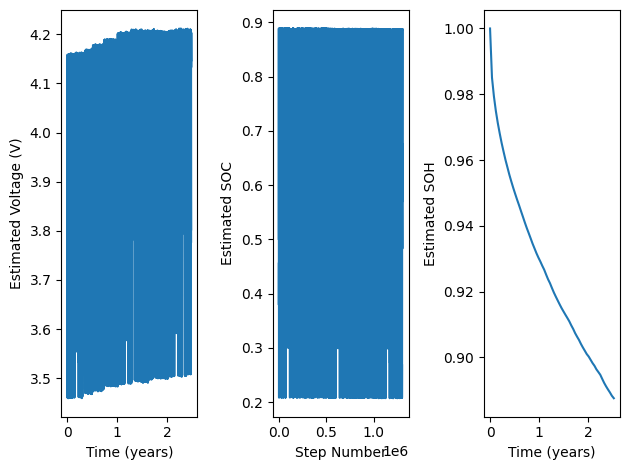

In [19]:
plot_result(sim_200kwh)

We see that the 200 kWh battery pack is greatly affected by the large DOD and is eventually encountering over voltages and in less than 3 years has lost the capacity to store the required power signal.

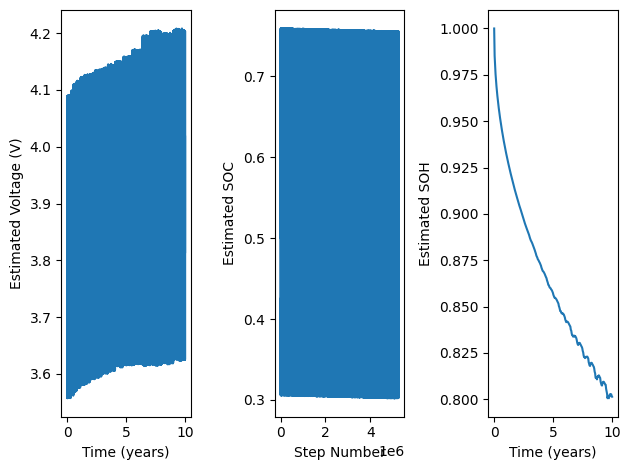

In [20]:
plot_result(sim_300kwh)

The 300 kWh battery fares better than the 200 kWh battery; however, it still struggles with over voltage occurances in the last few years of operation which suggests that it can't handle the power rates at higher SOC.